In [10]:
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1DfTETu5Xuz9lZP7bG2FNd1sc3ANS5M6_"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=174jvzyPTRvD9xTHttFIn1u3S3doATZ68"
! wget -O orion.jpg "https://drive.google.com/uc?export=download&id=1YpZAW3KZRjcIfdE4D1koOIeJoydHOYDM"
! wget -O point_tracker.html "https://drive.google.com/uc?export=download&id=1au-FWlvcbna05eBmoRiRLibXifwlT_vS"

--2026-02-03 21:04:47--  https://drive.google.com/uc?export=download&id=1DfTETu5Xuz9lZP7bG2FNd1sc3ANS5M6_
Resolving drive.google.com (drive.google.com)... 2607:f8b0:4001:c1d::8b, 2607:f8b0:4001:c1d::64, 2607:f8b0:4001:c1d::71, ...
Connecting to drive.google.com (drive.google.com)|2607:f8b0:4001:c1d::8b|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1DfTETu5Xuz9lZP7bG2FNd1sc3ANS5M6_&export=download [following]
--2026-02-03 21:04:47--  https://drive.usercontent.google.com/download?id=1DfTETu5Xuz9lZP7bG2FNd1sc3ANS5M6_&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 2607:f8b0:4001:c70::84, 142.250.191.129
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|2607:f8b0:4001:c70::84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116590 (114K) [image/jpeg]
Saving to: 'img1.jpg'

     0K .......... .......... .......... ...

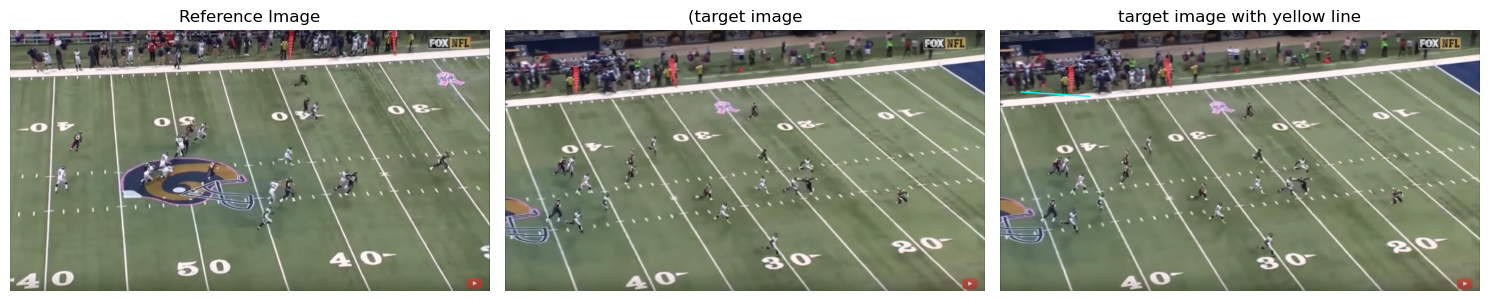

单应性矩阵H:
[[ 7.45214490e-01 -7.73964178e-02  5.10220960e+01]
 [ 4.95345161e-02  7.73884212e-01  7.34087936e+00]
 [ 1.44967913e-06 -3.87018331e-04  1.00000000e+00]]


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_homography(src_points, dst_points):
    """
    使用线性最小二乘法计算单应性矩阵
    
    参数:
    src_points: 源图像点 (n, 2)
    dst_points: 目标图像点 (n, 2)
    
    返回:
    H: 3x3单应性矩阵
    """
    n = src_points.shape[0]
    A = np.zeros((2*n, 8))
    b = np.zeros(2*n)
    
    for i in range(n):
        x, y = src_points[i]
        x_prime, y_prime = dst_points[i]
        
        # 构建矩阵A和向量b
        A[2*i] = [x, y, 1, 0, 0, 0, -x*x_prime, -y*x_prime]
        A[2*i+1] = [0, 0, 0, x, y, 1, -x*y_prime, -y*y_prime]
        
        b[2*i] = x_prime
        b[2*i+1] = y_prime
    
    # 使用最小二乘法求解: H_params = (A^T A)^(-1) A^T b
    H_params = np.linalg.lstsq(A, b, rcond=None)[0]
    
    # 构建完整的单应性矩阵
    H = np.array([
        [H_params[0], H_params[1], H_params[2]],
        [H_params[3], H_params[4], H_params[5]],
        [H_params[6], H_params[7], 1]
    ])
    
    return H

def transform_points(points, H):
    """
    使用单应性矩阵变换点集
    
    参数:
    points: 要变换的点 (n, 2)
    H: 3x3单应性矩阵
    
    返回:
    transformed_points: 变换后的点 (n, 2)
    """
    # 转换为齐次坐标
    homogeneous_points = np.column_stack([points, np.ones(len(points))])
    
    # 应用单应性变换
    transformed_homogeneous = H @ homogeneous_points.T
    transformed_homogeneous = transformed_homogeneous.T
    
    # 转换为笛卡尔坐标
    transformed_points = transformed_homogeneous[:, :2] / transformed_homogeneous[:, 2:3]
    
    return transformed_points

def draw_virtual_yellow_line():
    """
    主函数：实现虚拟黄线绘制
    """
    # 读取图像
    img1 = cv2.imread('img1.jpg')  # 基准图像（已标注黄线）
    img2 = cv2.imread('img2.jpg')  # 目标图像
    
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # 手动选择对应点（这里需要根据实际图像手动选择）
    # 示例点坐标，需要根据实际图像调整
    src_points = np.array([
        [100, 200],   # 球场角点1
        [300, 200],   # 球场角点2  
        [100, 400],   # 球场角点3
        [300, 400],   # 球场角点4
        [150, 300],   # 额外点1
        [250, 300]    # 额外点2
    ])
    
    dst_points = np.array([
        [120, 180],   # 对应点1
        [280, 190],   # 对应点2
        [110, 380],   # 对应点3  
        [290, 390],   # 对应点4
        [160, 280],   # 对应点5
        [240, 290]    # 对应点6
    ])
    
    # 计算单应性矩阵
    H = compute_homography(src_points, dst_points)
    
    # 定义基准图中的黄线端点（33码线位置）
    yellow_line_src = np.array([
        [50, 250],   # 黄线起点
        [350, 250]   # 黄线终点
    ])
    
    # 变换黄线到目标图像
    yellow_line_dst = transform_points(yellow_line_src, H)
    
    # 在目标图像上绘制黄线
    img2_with_line = img2_rgb.copy()
    start_point = tuple(yellow_line_dst[0].astype(int))
    end_point = tuple(yellow_line_dst[1].astype(int))
    
    # 绘制黄色线条（BGR格式的黄色）
    cv2.line(img2_with_line, start_point, end_point, (0, 255, 255), 3)
    
    # 显示结果
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img1_rgb)
    plt.title('Reference Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)  
    plt.imshow(img2_rgb)
    plt.title('(target image')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img2_with_line)
    plt.title('target image with yellow line')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return img2_with_line, H

# 运行主函数
if __name__ == "__main__":
    result_image, homography_matrix = draw_virtual_yellow_line()
    print("单应性矩阵H:")
    print(homography_matrix)

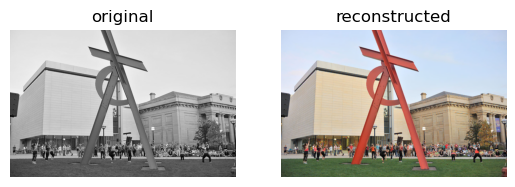

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def bayer_filter(img):
  # function bayer_filter filters an input color image I
  # by the Bayer pattern as below, and outputs a filtered color
  # image I and a gray scaled image I_gray in which the
  # value of every pixel is the intensity of corresponding
  # color.
  # b | g
  # -----
  # g | r
  rows, cols, _ = img.shape
  colored = img.copy()

  mask = np.zeros((2,2,3))
  mask[0,0,:] = [0,0,1] #blue
  mask[0,1,:] = [0,1,0] #green
  mask[1,0,:] = [0,1,0] #green
  mask[1,1,:] = [1,0,0] #red

  for row in range(rows):
    mask_row = row%2
    for col in range(cols):
      mask_col = col%2
      colored[row, col, :] = colored[row, col, :] * mask[mask_row, mask_col, :]
  gray = colored[:, :, 0] + colored[:, :, 1] + colored[:, :, 2]
  return colored, gray

def demosaic(bayer_image):
    height, width = bayer_image.shape
    bgr_image = np.zeros((height, width, 3), dtype=np.float32)
    
    for i in range(height):
        for j in range(width):
            if i % 2 == 0:
                if j % 2 == 0: bgr_image[i, j, 2] = bayer_image[i, j] # R
                else:          bgr_image[i, j, 1] = bayer_image[i, j] # G
            else:
                if j % 2 == 0: bgr_image[i, j, 1] = bayer_image[i, j] # G
                else:          bgr_image[i, j, 0] = bayer_image[i, j] # B

    for i in range(height):
        for j in range(width):
            if (i + j) % 2 != 1: 
                neighbors = []
                for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                    ni, nj = i+dx, j+dy
                    if 0 <= ni < height and 0 <= nj < width:
                        neighbors.append(bgr_image[ni, nj, 1])
                bgr_image[i, j, 1] = np.mean(neighbors)


    for i in range(height):
        for j in range(width):
            for c in [0, 2]: # 0:B, 2:R
                if bgr_image[i, j, c] == 0:
                    neighbors = []
                    for di in [-1, 0, 1]:
                        for dj in [-1, 0, 1]:
                            ni, nj = i+di, j+dj
                            if 0 <= ni < height and 0 <= nj < width:
                                is_original = (ni%2==0 and nj%2==0) if c==2 else (ni%2==1 and nj%2==1)
                                if is_original:
                                    neighbors.append(bgr_image[ni, nj, c])
                    if neighbors:
                        bgr_image[i, j, c] = np.mean(neighbors)

    return np.clip(bgr_image, 0, 255).astype(np.uint8)

color_image = cv2.imread('orion.jpg')  
colored, bayer_encoded = bayer_filter(color_image)
cv2.imwrite('grayscale.jpg', bayer_encoded)
reconstructed = demosaic(bayer_encoded) 
cv2.imwrite('reconstructed_bgr.jpg', reconstructed)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(bayer_encoded, cv2.COLOR_BGR2RGB))
plt.title("original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
plt.title("reconstructed")
plt.axis('off')
    
plt.show()